In [1]:
"""Imports necessary packages"""
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
schema = pd.read_csv("resources/nbi_record_format.csv")
schema.head()

,Unnamed: 0,ITEM NO,ITEM NAME,ITEM POSITION,ITEM LENGTH/TYPE
0,0,1,State Code,1 - 3,3/N
1,1,8,Structure Number,4 - 18,15/AN
2,2,5,Inventory Route,19 - 27,9/AN
3,3,5A,Record Type,19,1/AN
4,4,5B,Route Signing Prefix,20,1/N


In [3]:
for row in schema[["ITEM NO", "ITEM NAME"]].itertuples():
  print(row._1, row._2)

1 State Code
8 Structure Number
5 Inventory Route
5A Record Type
5B Route Signing Prefix
5C Designated Level of Service
5D Route Number
5E Directional Suffix
2 Highway Agency District
3 County (Parish) Code
4 Place Code
6 Features Intersected
6A Features Intersected
6B Critical Facility Indicator
7 Facility Carried By Structure
9 Location
10 Inventory Rte, Min Vert Clearance
11 Kilometerpoint
12 Base Highway Network
13 Inventory Route, Subroute Number
13A LRS Inventory Route
13B Subroute Number
16 Latitude
17 Longitude
19 Bypass/Detour Length
20 Toll
21 Maintenance Responsibility
22 Owner
26 Functional Class Of Inventory Rte.
27 Year Built
28 Lanes On/Under Structure
28A Lanes On Structure
28B Lanes Under Structure
29 Average Daily Traffic
30 Year Of Average Daily Traffic
31 Design Load
32 Approach Roadway Width
33 Bridge Median
34 Skew
35 Structure Flared
36 Traffic Safety Features
36A Bridge Railings
36B Transitions
36C Approach Guardrail
36D Approach Guardrail Ends
37 Historical sig

In [4]:
df = pd.read_csv('resources/slubkin_992016-20160126135704.txt')

/Users/joshuaarnold/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2,5,7,17,31,36,37,38,39,41,44,61,63,66,67,68,69,70,71,73,75,76,77,79,86,87,88,96,98,102,106,107,108,109,113,114,119,120,121,123,124,130,131,133) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.head()

,STATE_CODE_001,STRUCTURE_NUMBER_008,RECORD_TYPE_005A,ROUTE_PREFIX_005B,SERVICE_LEVEL_005C,ROUTE_NUMBER_005D,DIRECTION_005E,HIGHWAY_DISTRICT_002,COUNTY_CODE_003,PLACE_CODE_004,...,PROJ_NO,PROJ_SUFFIX,NBI_TYPE_OF_IMP,DTL_TYPE_OF_IMP,SPECIAL_CODE,STEP_CODE,STATUS_WITH_10YR_RULE,SUFFICIENCY_ASTERC,SUFFICIENCY_RATING,STATUS_NO_10YR_RULE
0,1,00000000000S702,1,6.0,1.0,04007,0.0,9,53.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,100.0,0
1,1,00000000000S703,1,6.0,1.0,04003,0.0,9,53.0,3004.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,100.0,0
2,1,0000000000M0022,1,8.0,1.0,00000,0.0,0,113.0,27568.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,68.5,0
3,1,000000883039900,1,4.0,1.0,00088,0.0,2,59.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,90.2,0
4,1,000001014002450,1,3.0,1.0,00101,0.0,2,79.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,59.0,2


In [6]:
[v for v in df.columns if "107" in v.lower()]

['DECK_STRUCTURE_TYPE_107']

In [7]:
df.DECK_STRUCTURE_TYPE_107

0           2
1           2
2           1
3           1
4           1
5           1
6           6
7           6
8           1
9           8
10          2
11          1
12          2
13          N
14          1
15          8
16          1
17          1
18          1
19          N
20          8
21          8
22          8
23          8
24          1
25          1
26          8
27          N
28          3
29          3
         ... 
723272    NaN
723273    NaN
723274    NaN
723275    NaN
723276    NaN
723277    NaN
723278    NaN
723279    NaN
723280    NaN
723281    NaN
723282    NaN
723283    NaN
723284    NaN
723285    NaN
723286    NaN
723287    NaN
723288    NaN
723289    NaN
723290    NaN
723291    NaN
723292    NaN
723293    NaN
723294    NaN
723295    NaN
723296    NaN
723297    NaN
723298    NaN
723299    NaN
723300    NaN
723301    NaN
Name: DECK_STRUCTURE_TYPE_107, dtype: object

## Numeric features
Try to pull out some features that make sense as predictors of sufficiency.

In [8]:
# Average daily traffic for trucks
df['TRUCK_ADT'] = df.ADT_029*df.PERCENT_ADT_TRUCK_109/100

# Age of bridge
df['AGE'] = 2016 - df.YEAR_BUILT_027

features = ['AGE',
            'ADT_029',
            'TRUCK_ADT',
            'STRUCTURE_LEN_MT_049',
            'TRAFFIC_LANES_ON_028A']

label_col = 'SUFFICIENCY_RATING'

Unfortunately, these features (other than age) aren't very strongly correlated with the SR, so a linear model may not work well.

In [9]:
df.loc[:,features+[label_col]].corr()

,AGE,ADT_029,TRUCK_ADT,STRUCTURE_LEN_MT_049,TRAFFIC_LANES_ON_028A,SUFFICIENCY_RATING
AGE,1.000000,-0.021259,-0.024435,-0.047113,-0.067606,-0.500184
ADT_029,-0.021259,1.000000,0.722974,0.109050,0.438974,0.013651
TRUCK_ADT,-0.024435,0.722974,1.000000,0.082236,0.311347,0.025192
STRUCTURE_LEN_MT_049,-0.047113,0.109050,0.082236,1.000000,0.056318,0.006308
TRAFFIC_LANES_ON_028A,-0.067606,0.438974,0.311347,0.056318,1.000000,0.052400
SUFFICIENCY_RATING,-0.500184,0.013651,0.025192,0.006308,0.052400,1.000000


Try fitting a basic linear regression model.

In [10]:
from sklearn.linear_model import LinearRegression

df_sub = df[features + [label_col]].dropna(axis=0)

X = df_sub[features]
y = df_sub[label_col]

model = LinearRegression()
model.fit(X, y)
model.score(X, y)

0.25424854857356638

Look at the feature importances.

In [11]:
import prettytable

t = prettytable.PrettyTable()
t.field_names = ["Feature", "Weight"]
t.align["Feature"] = "l"

t.float_format["Weight"] = "0.8"

for fw in sorted(zip(features, np.abs(model.coef_)), key=lambda x: x[1], reverse=True):
  t.add_row(fw)
  
print(t)

+-----------------------+------------+
| Feature               |   Weight   |
+-----------------------+------------+
| AGE                   | 0.37031184 |
| TRAFFIC_LANES_ON_028A | 0.13865022 |
| STRUCTURE_LEN_MT_049  | 0.00323628 |
| TRUCK_ADT             | 0.00039252 |
| ADT_029               | 0.00002600 |
+-----------------------+------------+


The SR appears to vary somewhat linearly with AGE.

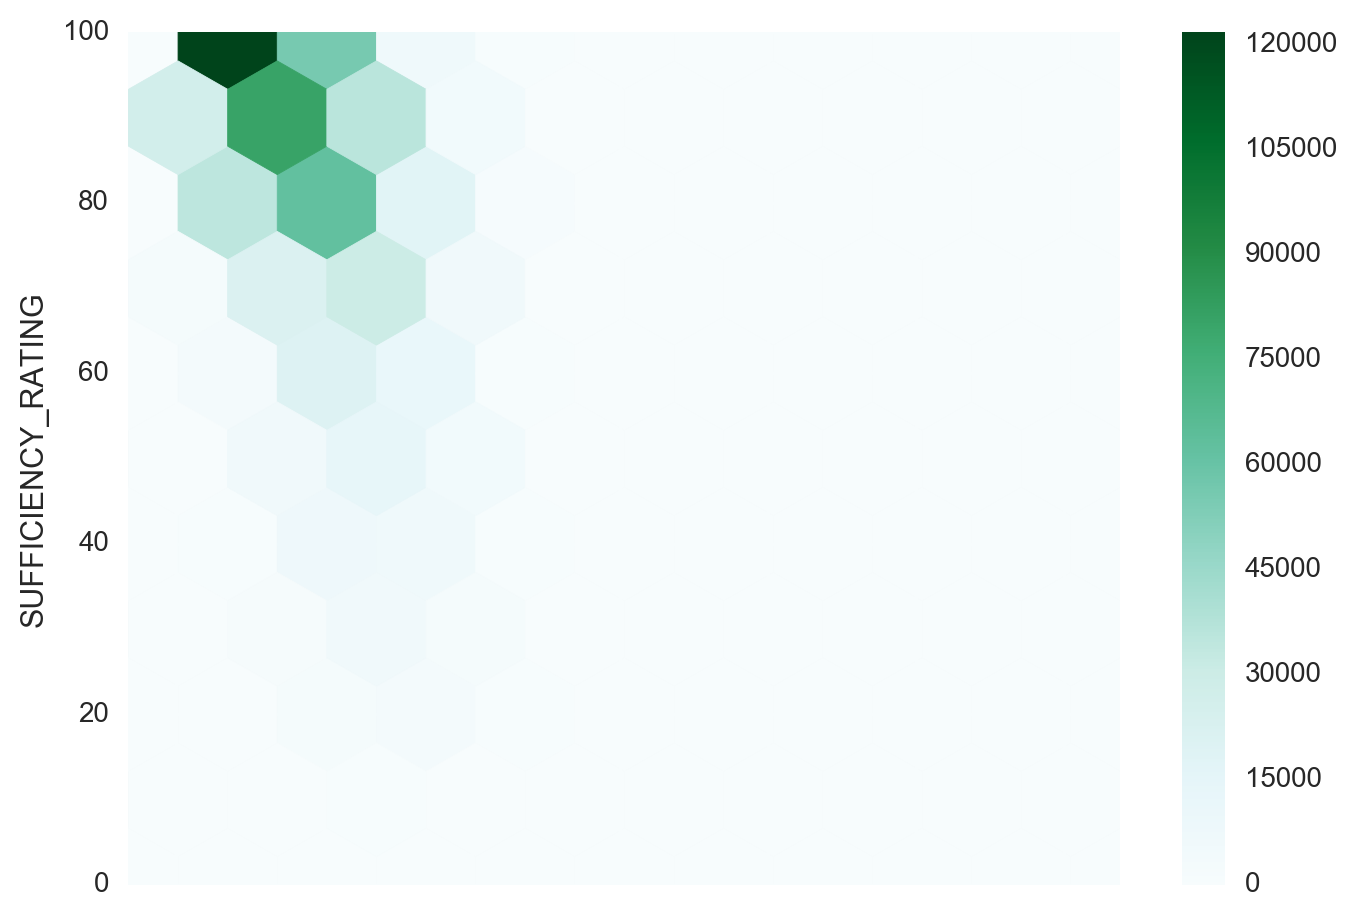

In [12]:
df.plot.hexbin(x="AGE", y=label_col, gridsize=10)

## Regularization
Switch to a regularized model to constrain weights.

In [ ]:
from sklearn.linear_model import Ridge

df_sub = df[features + [label_col]].dropna(axis=0)

X = df_sub[features]
y = df_sub[label_col]

model = Ridge(alpha=0.2)
model.fit(X, y)
model.score(X, y)

Use cross-validation to choose the optimal hyperparameter `alpha`

In [ ]:
from sklearn.linear_model import RidgeCV

df_sub = df[features + [label_col]].dropna(axis=0)

X = df_sub[features]
y = df_sub[label_col]

model = RidgeCV(alphas=[0.3 ** i for i in range(1,5)])
model.fit(X, y)
print("Score: {0} alpha: {1}".format(model.score(X, y), model.alpha_))


Try a random forest regressor.

In [33]:
%load_ext autoreload

In [34]:
%autoreload 2

from helpers import compute_test_train_error



In [ ]:
from sklearn.ensemble import RandomForestRegressor


df_sub = df[features + [label_col]].dropna(axis=0).reset_index(drop=True)

X = df_sub[features]
y = df_sub[label_col].as_matrix()

models = [Ridge(), RandomForestRegressor()]

for m in models:
  print(m)
  compute_test_train_error(m, X, y)
  print()



The RF is more accurate, but it actually overfitting the data. Let's try bringing in more features and fitting with the Ridge model.


For this, we can use Categorical data
```
Item 107 - Deck Structure Type

         Code               Description
           1                Concrete Cast-in-Place
           2                Concrete Precast Panels
           3                Open Grating
           4                Closed Grating
           5                Steel plate (includes orthotropic)
           6                Corrugated Steel
           7                Aluminum
           8                Wood or Timber
           9                Other
           N                Not applicable
```

Categorical data needs to be vectorized, that is mapped to some $n$-dimensional space.

In [13]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

df_sub = df[["DECK_STRUCTURE_TYPE_107"]].dropna().reset_index(drop=True)

le = LabelEncoder()
df_sub["integer_labels"] = le.fit_transform(df_sub.DECK_STRUCTURE_TYPE_107)

enc = OneHotEncoder()
sparse_vectorized = enc.fit_transform(df_sub[["integer_labels"]])
df_sub = pd.concat([df_sub, 
                    pd.DataFrame(sparse_vectorized.todense(), columns=le.classes_)
                    ], axis=1)
df_sub


,DECK_STRUCTURE_TYPE_107,integer_labels,1,2,3,4,5,6,7,8,9,N
0,2,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,6,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,8,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Unfortunately, there is a real deficiency in scikit-learn for vectorizing categorical data. Instead, we have to roll our own Transformers.

`SelectTransformer` is used to select a specific column from a `DataFrame`.

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class SelectTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, columns):
    self.columns = columns
    
  def fit(self, X, y=None):
    return self
  
  def transform(self, df):
    return df[self.columns].as_matrix()

`CategoricalTransformer` takes a column array and combines two built-in functions to vectorize string categories.

In [15]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

  
class CategoricalTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.le = LabelEncoder()
    self.ohe = OneHotEncoder()
  
  def fit(self, X, y=None):
    return self
  
  def transform(self, X):
    labels = self.le.fit_transform(X.ravel())
    return self.ohe.fit_transform(labels.reshape(-1,1))


In [ ]:
SelectTransformer(["DECK_STRUCTURE_TYPE_107"]).transform(df)

In [ ]:
CategoricalTransformer().fit_transform(
  SelectTransformer(["DECK_STRUCTURE_TYPE_107"]).transform(df_sub)
)

`Pipeline`s describe both the (*serial*) data transformations and the ultimate Regressor/Classifier that constitute a model.

`FeatureUnion`s are used to combine features from disparate sources in *parallel*.

In [21]:
X_t = feats.transform(X)
X_t

<45403x15 sparse matrix of type '<class 'numpy.float64'>'
	with 265967 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_regression, SelectFromModel
from sklearn.ensemble import RandomForestRegressor

if 1:
  df_sub = df\
    .dropna(axis=0, subset=features + ["DECK_STRUCTURE_TYPE_107", label_col]).reset_index(drop=True)

  X = df_sub
  y = df_sub[label_col].as_matrix()

  feats = FeatureUnion([
            ("deck_struct", 
            Pipeline([
              ("deck", SelectTransformer(["DECK_STRUCTURE_TYPE_107"])),
              ("one_hot", CategoricalTransformer()),               
              ])),
            ("linear", SelectTransformer(features))
          ])

  X_t = feats.transform(X)

pipe = Pipeline([
    ('feature_selection', SelectFromModel(RandomForestRegressor())),
    ("model", RandomForestRegressor()),
    ])
# pipe.fit(X_t, y)

compute_test_train_error(pipe, X_t, y)


Training split 1 of 3


In [ ]:
bins = np.linspace(1800,2016,50)
ax = df.YEAR_BUILT_027.hist(bins=bins)
ax.set_ylabel('Number of Bridges')
ax.set_xlabel('Year Built')
df.loc[(df.HISTORY_037 >= 1) & (df.HISTORY_037 <= 3),'YEAR_BUILT_027'].hist(bins=bins,ax=ax)